IMPORTS

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import mixture
import pandas as pd
import time
from zero_point import zpt
import sys
import os
import itertools
import matplotlib as mpl

ModuleNotFoundError: No module named 'numpy'

A PRIOR KNOWLEDGE

In [2]:


#choose the right centroid from prior knowledge or rough estimates
def wise(kp,pcov):
    #rough estimates
    guess_ra = 290.2336
    guess_dec = 37.7827
    guess_pmra = -0.4300
    guess_pmdec = -2.251 
    guess_plx = 0.2357

    l = (kp[:,1]-guess_pmra)**2 + (kp[:,2]-guess_pmdec)**2 + (kp[:,3]-guess_plx)**2 + (kp[:,4]-guess_ra)**2 + (kp[:,5]-guess_dec)**2
    centroid = np.where(l==min(l))[0][0]
    return centroid


GAUSSIAN MIXTURE MODEL WITH DIRICHLET PROCESS PRIOR


In [3]:
def gauss_mix(X,n,mode,plot=False):
    if mode =='dpgmm':
        # Fit a Dirichlet process Gaussian mixture using five components
        dpgmm = mixture.BayesianGaussianMixture(n_components=n,
                                                covariance_type='full',random_state=1,max_iter=5000).fit(X)
        print('Bayesian Gaussian Mixture with a Dirichlet process prior')
        centers = np.empty(shape=(dpgmm.n_components, X.shape[1]))
        kp = np.zeros(1)
        for i in range(dpgmm.n_components):
            density = scipy.stats.multivariate_normal(cov=dpgmm.covariances_[i], mean=dpgmm.means_[i]).logpdf(X)
            centers[i, :] = X[np.argmax(density)]
            kp = np.vstack((kp,i))

        if plot == True:
            plt.scatter(centers[:, 0], centers[:, 1], s=20,marker='*')
            plt.show()
        pcov = dpgmm.covariances_
        print('Full covariance matrices', pcov)
        p=dpgmm.predict_proba(X)
        q=dpgmm.predict(X)
        mu = dpgmm.means_
    else:
        # Fit a Gaussian mixture with EM using five components
        gmm = mixture.GaussianMixture(n_components=n, covariance_type='full',random_state=1).fit(X)
        print('Gaussian Mixture Results')
        centers = np.empty(shape=(gmm.n_components, X.shape[1]))
        kp = np.zeros(1)
        for i in range(gmm.n_components):
            density = scipy.stats.multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
            centers[i, :] = X[np.argmax(density)]
            kp = np.vstack((kp,i))

        if plot == True:
            plt.scatter(centers[:, 0], centers[:, 1], s=20,marker='*',color='red')
            plt.show()

        pcov = gmm.covariances_
        print('Full covariance matrices', pcov)
        p=gmm.predict_proba(X)
        q=gmm.predict(X)

    if np.shape(X)[1] == 2:
        kp = np.column_stack((kp[1:],centers[:, 0]))
        kp = np.column_stack((kp, centers[:, 1]))
    elif np.shape(X)[1] == 3:
        kp = np.column_stack((kp[1:],centers[:, 0]))
        kp = np.column_stack((kp, centers[:, 1]))
        kp = np.column_stack((kp, centers[:, 2]))
    elif np.shape(X)[1] == 4:
        kp = np.column_stack((kp[1:],centers[:, 0]))
        kp = np.column_stack((kp, centers[:, 1]))
        kp = np.column_stack((kp, centers[:, 2]))
        kp = np.column_stack((kp, centers[:, 3]))
    elif np.shape(X)[1] == 5:
        kp = np.column_stack((kp[1:],centers[:, 0]))
        kp = np.column_stack((kp, centers[:, 1]))
        kp = np.column_stack((kp, centers[:, 2]))
        kp = np.column_stack((kp, centers[:, 3]))
        kp = np.column_stack((kp, centers[:, 4]))
    elif np.shape(X)[1] == 6:
        kp = np.column_stack((kp[1:],centers[:, 0]))
        kp = np.column_stack((kp, centers[:, 1]))
        kp = np.column_stack((kp, centers[:, 2]))
        kp = np.column_stack((kp, centers[:, 3]))
        kp = np.column_stack((kp, centers[:, 4]))
        kp = np.column_stack((kp, centers[:, 5]))
            
    print('Centeroids')
    print(kp)

    return p,q,kp,pcov,mu


ADQL PYTHON QUERY FOR DOWNLOADING GAIA DATA FROM A SELECTED PART OF THE SKY

In [ ]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia        

#cluster center
#ra, dec, radius = 290.21375,37.77388888888889,0.38333333333333336 # fov6791_kamann_23
ra, dec, radius = 295.32166666666666,40.18833333333333,0.38333333333333336 # fov6819_kamann_23


job = Gaia.launch_job_async("SELECT TOP 10000000 * "
                            "FROM gaiadr3.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),"
                            "CIRCLE('ICRS',"+str(ra)+","+str(dec)+","+str(radius)+"))=1",
                            dump_to_file=True, output_format='csv')
r = job.get_results()
print(r)



LOADING GAIA DATA OF THE FIELD OF VIEW

In [4]:
#data
file_name = 'FOV_6791.csv'
fname = os.path.splitext(file_name)[0]
print(fname)

tstart = time.time()
df1 = pd.read_csv(file_name)


FOV_6791


PARAMETER PLOTS IN THE FIELD OF VIEW

Text(0, 0.5, 'parallax')

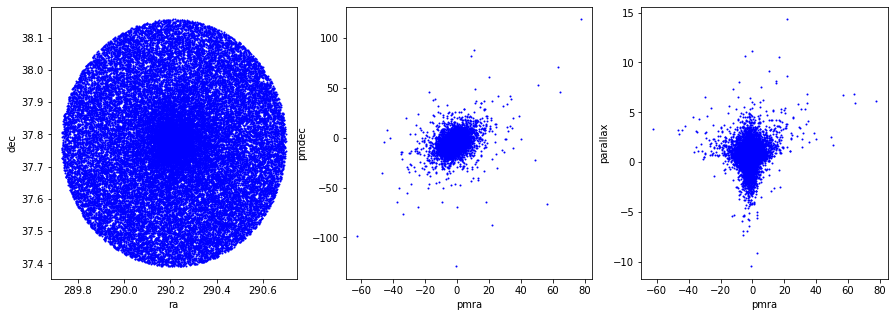

In [5]:
#plot distribution all stars
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(df1.ra,df1.dec,'.',ms=2,color='blue')
plt.xlabel('ra')
plt.ylabel('dec')
plt.subplot(132)
plt.plot(df1.pmra,df1.pmdec,'.',ms=2,color='blue')
plt.xlabel('pmra')
plt.ylabel('pmdec')
plt.subplot(133)
plt.plot(df1.pmra,df1.parallax,'.',ms=2,color='blue')
plt.xlabel('pmra')
plt.ylabel('parallax')


PARAMETER DISTRIBUTION IN THE FOV

(-5.0, 5.0)

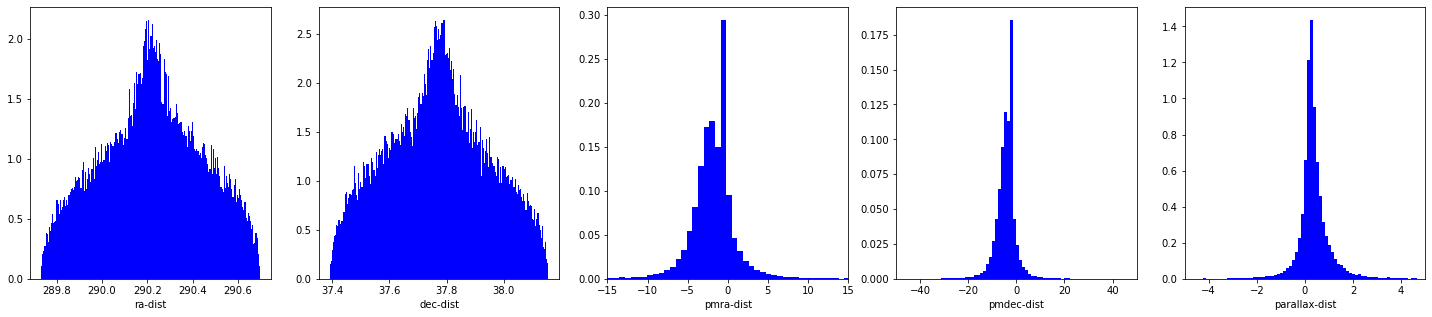

In [6]:
#plot distribution

#plot distribution all stars
plt.figure(figsize=(25,5))
plt.subplot(151)
plt.hist(df1.ra,200,density=True,histtype='bar',facecolor='b')
plt.xlabel('ra-dist')


plt.subplot(152)
plt.hist(df1.dec,200,density=True,histtype='bar',facecolor='b')
plt.xlabel('dec-dist')

plt.subplot(153)
plt.hist(df1.pmra,200,density=True,histtype='bar',facecolor='b')
plt.xlabel('pmra-dist')
plt.xlim(-15,15)

plt.subplot(154)
plt.hist(df1.pmdec,200,density=True,histtype='bar',facecolor='b')
plt.xlabel('pmdec-dist')
plt.xlim(-50,50)

plt.subplot(155)
plt.hist(df1.parallax,200,density=True,histtype='bar',facecolor='b')
plt.xlabel('parallax-dist')
plt.xlim(-5,5)

GAIA DATA PROCESSING FOR GMM ANALYSIS

In [7]:
print('original data: ',len(df1))
df1 = df1[np.isfinite(df1['pmra'])]
df1 = df1[np.isfinite(df1['pmdec'])]
print('after proper-motion nan correction: ',len(df1))
df1 = df1[np.isfinite(df1['parallax'])]
print('after parallax nan correction:', len(df1))
#df1 = df1[np.isfinite(df1['radial_velocity'])]
#print('after radial_velocity nan correction:', len(df1))

#uncertainity filter
df1['un_pmra'] = abs(df1['pmra_error']/df1['pmra'])*100
df1 = df1[df1.un_pmra<=50]
print('after pmra uncertainity filter: ',len(df1))
df1['un_pmdec'] = abs(df1['pmdec_error']/df1['pmdec'])*100
df1 = df1[df1.un_pmdec<=50]
print('after pmdec uncertainity filter: ',len(df1))

df1 = df1[df1.astrometric_params_solved>3] # removing 3 parameter solutions
#zeropoint from lindgren 2020, adsurl = https://ui.adsabs.harvard.edu/abs/2020arXiv201201742L
zpt.load_tables()
df1['zero_point'] = df1.apply(zpt.zpt_wrapper,axis=1)
df1.parallax = df1.parallax - df1.zero_point # zeropoint correction
print('After removing 3 parameter solutions: ',len(df1))

df1['un_plx'] = abs(df1['parallax_error']/df1['parallax'])*100
df1 = df1[df1.un_plx<=50]
print('after parallax uncertainity filter: ',len(df1))

#filtering forground stars and stars with negetive parallalxes
df1 = df1[(df1.parallax>0)&(df1.parallax<1)]
print('after parallax field filter: ',len(df1))

p1 = df1.pmra
p2 = df1.pmdec
p3 = df1.parallax
#p4 = df1.radial_velocity
p5 = df1.ra
p6 = df1.dec

X = np.column_stack([p1,p2])
X = np.column_stack([X,p3])
#X = np.column_stack([X,p4])
X = np.column_stack([X,p5])
X = np.column_stack([X,p6])

XX = np.column_stack([df1.designation,X])
print('Final data length before gmm : ', len(df1))



original data:  36647
after proper-motion nan correction:  33668
after parallax nan correction: 33668
after pmra uncertainity filter:  27911
after pmdec uncertainity filter:  26934
After removing 3 parameter solutions:  26934
after parallax uncertainity filter:  13417
after parallax field filter:  11466
Final data length before gmm :  11466
Bayesian Gaussian Mixture with a Dirichlet process prior
Full covariance matrices [[[ 1.50507343e-02  4.18974141e-03 -1.19045978e-03  2.69107650e-04
   -7.09887367e-07]
  [ 4.18974141e-03  2.42818357e-02 -8.19840557e-04  3.79308561e-04
    3.50272065e-04]
  [-1.19045978e-03 -8.19840557e-04  5.02430545e-03 -1.41439947e-04
    5.86778368e-05]
  [ 2.69107650e-04  3.79308561e-04 -1.41439947e-04  6.75615384e-03
    1.12151402e-04]
  [-7.09887367e-07  3.50272065e-04  5.86778368e-05  1.12151402e-04
    4.43793525e-03]]

 [[ 1.76770300e+00  1.26741437e+00 -1.03215737e-02 -1.26842679e-02
    2.46184065e-02]
  [ 1.26741437e+00  4.48851255e+00  7.62997508e-02 

RUNNING GMM MODELS WITH 15 GAUSSIAN FUNCTIONS

In [ ]:
#GMM
p,q,kp,pcov,mu = gauss_mix(X,15,'dpgmm') # Define number of gaussian components
print(p)
print(q)


FUNCTIONS FOR PLOTING EIGEN VALUES AND EIGEN VECTORS

In [8]:

def plot_results(X, Y_, means, covariances, index, title,par1,par2):
    color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, par1], X[Y_ == i, par2], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        #ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        #ell.set_alpha(0.5)
        #plot.add_artist(ell)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

In [9]:

def plot_hist(X, Y_, means, covariances, index, title,par1):
    color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        #plt.scatter(X[Y_ == i, par1], X[Y_ == i, par2], 0.8, color=color)
        plt.hist(X[Y_ == i, par1],200,density=True,histtype='bar',facecolor=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        #ell = mpl.patches.Ellipse(mean, v[0], v[1], 180.0 + angle, color=color)
        #ell.set_clip_box(splot.bbox)
        #ell.set_alpha(0.5)
        #plot.add_artist(ell)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

PARAMETER INFERENCES FROM GMM

Text(0, 0.5, 'pmdec')

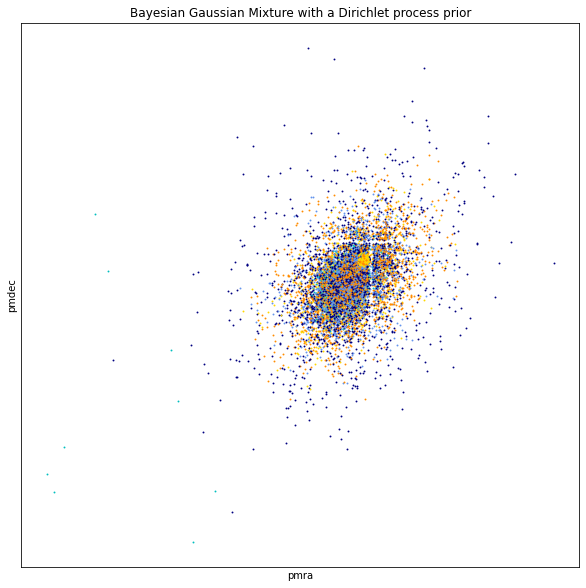

In [10]:
par1,par2 = 0,1
plt.figure(figsize=(10,10))
plot_results(X,q,mu,pcov,1,"Bayesian Gaussian Mixture with a Dirichlet process prior",par1,par2)
plt.xlabel('pmra')
plt.ylabel('pmdec')


PARAMETER DISTRIBUTION FROM GMM INFERENCE

Text(0.5, 0, 'pmra')

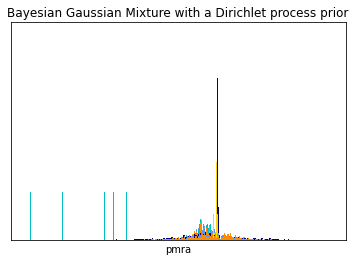

In [11]:
par1 = 0
plot_hist(X,q,mu,pcov,1,"Bayesian Gaussian Mixture with a Dirichlet process prior",par1)
plt.xlabel('pmra')

USING THE PRIOR KNOWLEDGE TO CHOOS ETHE BEST GAUSSIAN

In [12]:
c = wise(kp,pcov)
#c = int(input('Enter the centroid: ')) # manually choose the centroid

c = np.array([c])
print('Guess results! : ',kp[c,:])
print('Guess Covariance matrix: ',pcov[c])

Guess results! :  [[ 0.00000000e+00 -4.50387470e-01 -2.29820356e+00  2.63035221e-01
   2.90220284e+02  3.77757136e+01]]
Guess Covariance matrix:  [[[ 1.50507343e-02  4.18974141e-03 -1.19045978e-03  2.69107650e-04
   -7.09887367e-07]
  [ 4.18974141e-03  2.42818357e-02 -8.19840557e-04  3.79308561e-04
    3.50272065e-04]
  [-1.19045978e-03 -8.19840557e-04  5.02430545e-03 -1.41439947e-04
    5.86778368e-05]
  [ 2.69107650e-04  3.79308561e-04 -1.41439947e-04  6.75615384e-03
    1.12151402e-04]
  [-7.09887367e-07  3.50272065e-04  5.86778368e-05  1.12151402e-04
    4.43793525e-03]]]


ADDING THE PROBABILITY STATISTICS TO THE GAIA DATA

In [13]:
#Stacking probability data from the gaussian and saving
gdata = np.column_stack([XX,q])
pb = np.zeros(len(p))
gmm_prob = np.zeros(1)
for j in range(len(p)):
    pb[j] = p[j][q[j]]
    gmm_prob = np.vstack((gmm_prob,p[j][int(c)]))
gdata = np.column_stack([gdata,pb])
df1['gmm_prob'] = gmm_prob[1:]
df1.to_csv(fname+'_GEDR3_GMM_5D_ppt.csv')

MEMBERSHIP ANALYSIS ON VARIOUS PARAMETERS

Almost certain members :  2040


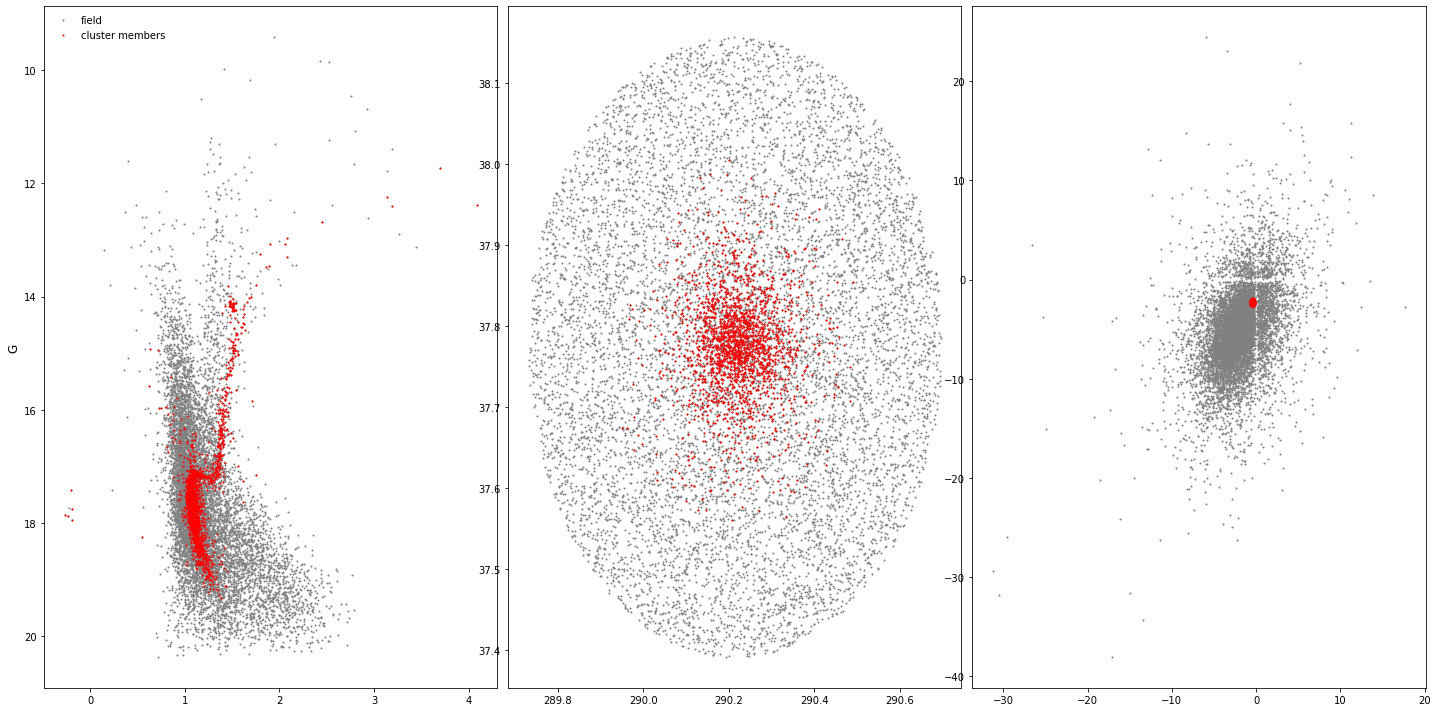

In [14]:

df = pd.read_csv(fname+'_GEDR3_GMM_5D_ppt.csv')
pt = 0.9 #using a probbaility filter of 90%
print('Almost certain members : ', len(df[df.gmm_prob>pt]))
dngc = df[df.gmm_prob > pt]
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.plot(df.bp_rp,df.phot_g_mean_mag,'.',ms=2,color='grey',label=r'field')
plt.plot(dngc.bp_rp,dngc.phot_g_mean_mag,'.',ms=2,color='red',label=r'cluster members')
plt.gca().invert_yaxis()
plt.legend(loc=2,frameon=False)
plt.ylabel(r'G',size = 12)
plt.tight_layout()

plt.subplot(1,3,2)
plt.plot(df.ra,df.dec,'.',ms=2,color='grey',label=r'field')
plt.plot(dngc.ra,dngc.dec,'.',ms=2,color='red',label=r'cluster members')

plt.subplot(1,3,3)
plt.plot(df.pmra,df.pmdec,'.',ms=2,color='grey',label=r'field')
plt.plot(dngc.pmra,dngc.pmdec,'.',ms=2,color='red',label=r'cluster members')




MEMBERSHIP DISTRIBUTION 

(-5.0, 5.0)

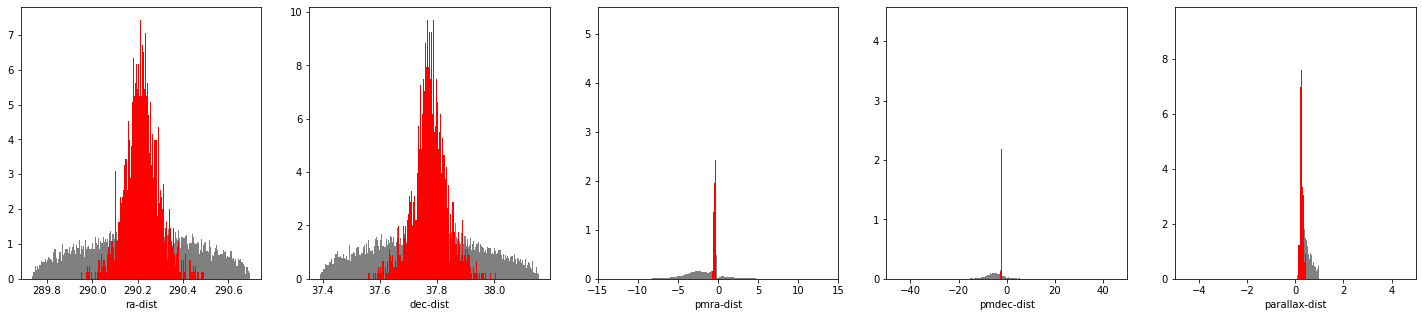

In [15]:
#plot distribution
#%matplotlib
#plot distribution all stars
plt.figure(figsize=(25,5))
plt.subplot(151)
plt.hist(df.ra,200,density=True,histtype='bar',facecolor='grey')
plt.hist(dngc.ra,200,density=True,histtype='bar',facecolor='r')
plt.xlabel('ra-dist')


plt.subplot(152)
plt.hist(df.dec,200,density=True,histtype='bar',facecolor='grey')
plt.hist(dngc.dec,200,density=True,histtype='bar',facecolor='r')
plt.xlabel('dec-dist')

plt.subplot(153)
plt.hist(df.pmra,200,density=True,histtype='bar',facecolor='grey')
plt.hist(dngc.pmra,200,density=True,histtype='bar',facecolor='r')
plt.xlabel('pmra-dist')
plt.xlim(-15,15)

plt.subplot(154)
plt.hist(df.pmdec,200,density=True,histtype='bar',facecolor='grey')
plt.hist(dngc.pmdec,200,density=True,histtype='bar',facecolor='r')
plt.xlabel('pmdec-dist')
plt.xlim(-50,50)

plt.subplot(155)
plt.hist(df.parallax,200,density=True,histtype='bar',facecolor='grey')
plt.hist(dngc.parallax,200,density=True,histtype='bar',facecolor='r')
plt.xlabel('parallax-dist')
plt.xlim(-5,5)

FINDING THE OPTIMAL PARAMETERS OF THE CLUSTER FROM GMM USING THE CENTRIODS OF THE GAUSSIAN AND COVARIANCE MATRIX

In [19]:

############################################################################
#deriving the cluster parameters from most probable members of the cluster
#PROBABILITY DECISION
df = pd.read_csv(fname+'_GEDR3_GMM_5D_ppt.csv')
pt = 0.9 #using a probbaility filter of 90%
print('Almost certain members : ', len(df[df.gmm_prob>pt]))

df = df[df.gmm_prob > pt]

p1 = df.pmra
p2 = df.pmdec
p3 = df.parallax
p4 = df.ra
p5 = df.dec

X = np.column_stack([p1,p2])
X = np.column_stack([X,p3])
X = np.column_stack([X,p4])
X = np.column_stack([X,p5])

#GMM
p,q,kp,pcov,mu = gauss_mix(X,15,'dpgmm')
#print(p)
#print(q)

#choose the right centroid from priors
c = wise(kp,pcov)
#c = int(input('Enter the centroid: '))

c = np.array([c])
#print('Guess results! : ',kp[c,:])
#print('Guess Covariance matrix: ',pcov[c])
print('*Cluster parameters derived from most probable members')
print('pmra:  ',kp[c,1][0], ' +- ' , np.sqrt(pcov[c][0][0][0]/len(df))) 
print('pmdec: ',kp[c,2][0], ' +- ' , np.sqrt(pcov[c][0][1][1]/len(df)))
print('plx:   ',kp[c,3][0], ' +- ' , np.sqrt(pcov[c][0][2][2]/len(df)))
print('ra:    ',kp[c,4][0], ' +- ' , np.sqrt(pcov[c][0][3][3]/len(df)))
print('dec:   ',kp[c,5][0], ' +- ' , np.sqrt(pcov[c][0][4][4]/len(df)))
#print('ra: ',np.mean(p5),np.std(p5)/2036., ', dec: ',np.mean(p4),np.std(p4)/2036, ', pmra: ',np.mean(p1),np.std(p1)/2036, ', pmdec: ',np.mean(p2),np.std(p2)/2036, ', parallax:',np.mean(p3),np.std(p3)/2036)

print('Time Elasped: ',time.time()-tstart,' seconds')


Almost certain members :  2040
Bayesian Gaussian Mixture with a Dirichlet process prior
Full covariance matrices [[[ 2.06130628e-03  1.41453469e-04 -1.54147051e-04  4.74574011e-05
   -9.97385039e-06]
  [ 1.41453469e-04  2.66901678e-03 -9.73762427e-05  5.26094317e-05
    6.99289690e-05]
  [-1.54147051e-04 -9.73762427e-05  8.24972284e-04 -3.43952613e-05
    8.72926966e-06]
  [ 4.74574011e-05  5.26094317e-05 -3.43952613e-05  1.23336444e-03
    1.47894926e-05]
  [-9.97385039e-06  6.99289690e-05  8.72926966e-06  1.47894926e-05
    8.08525970e-04]]

 [[ 3.40094466e-03 -6.52800017e-04 -7.09609572e-04 -1.70132832e-03
   -2.66116451e-04]
  [-6.52800017e-04  2.61153037e-03  5.71377751e-04 -8.64454724e-04
    5.92839340e-04]
  [-7.09609572e-04  5.71377751e-04  7.30818395e-04 -2.09177266e-04
    2.49613180e-04]
  [-1.70132832e-03 -8.64454724e-04 -2.09177266e-04  4.87932216e-03
   -7.79790811e-04]
  [-2.66116451e-04  5.92839340e-04  2.49613180e-04 -7.79790811e-04
    7.66852479e-04]]

 [[ 7.4655481

In [ ]:
print('*Cluster parameters derived from most probable members')
print('pmra:  ',kp[c,1][0], ' +- ' , np.sqrt(pcov[c][0][0][0]/len(df))) 
print('pmdec: ',kp[c,2][0], ' +- ' , np.sqrt(pcov[c][0][1][1]/len(df)))
print('plx:   ',kp[c,3][0], ' +- ' , np.sqrt(pcov[c][0][2][2]/len(df)))
print('ra:    ',kp[c,4][0], ' +- ' , np.sqrt(pcov[c][0][3][3]/len(df)))
print('dec:   ',kp[c,5][0], ' +- ' , np.sqrt(pcov[c][0][4][4]/len(df)))
#print('ra: ',np.mean(p5),np.std(p5)/2036., ', dec: ',np.mean(p4),np.std(p4)/2036, ', pmra: ',np.mean(p1),np.std(p1)/2036, ', pmdec: ',np.mean(p2),np.std(p2)/2036, ', parallax:',np.mean(p3),np.std(p3)/2036)

print('Time Elasped: ',time.time()-tstart,' seconds')